# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.0


## Download data and generate sequences

Download quijote from guttenberg project

wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2117498
Chars list:  ['\n', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü', '\ufeff']
total chars: 72


In [ ]:
# Simplify text to improve the semantic capacities of the model.
replace_dir={}


In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(3000, len(text) - maxlen, step): #Start in character 3000 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 705726
tregará a medea; si  - d


## Train the model

In [4]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (705726, 20, 72)
y shape:  (705726, 72)


In [5]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras import optimizers

print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(1024, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(seq_prev_input)

forwards2 = LSTM(1024, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(forwards1)

output = Dense(len(chars), activation='softmax')(forwards2)

model = Model(inputs=seq_prev_input, outputs=output)
model.summary()

# try using different optimizers and different optimizer configs
Nadam = optimizers.Nadam(lr=0.0002, schedule_decay=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 20, 72)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 1024)          4493312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 72)                73800     
Total params: 12,959,816.0
Trainable params: 12,959,816.0
Non-trainable params: 0.0
_________________________________________________________________


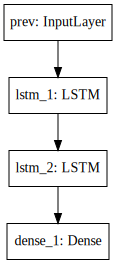

In [6]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
#Fit model
history = model.fit(X[:600000], y[:600000], batch_size=256, epochs=50,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 105726 samples
Epoch 1/50
600000/600000 [==============================] - 306s - loss: 2.2753 - acc: 0.3206 - val_loss: 1.9601 - val_acc: 0.4098
Epoch 2/50
600000/600000 [==============================] - 306s - loss: 1.7904 - acc: 0.4468 - val_loss: 1.7279 - val_acc: 0.4898
Epoch 3/50
600000/600000 [==============================] - 307s - loss: 1.5911 - acc: 0.5049 - val_loss: 1.6220 - val_acc: 0.5230
Epoch 4/50
600000/600000 [==============================] - 306s - loss: 1.4794 - acc: 0.5368 - val_loss: 1.5782 - val_acc: 0.5406
Epoch 5/50
600000/600000 [==============================] - 306s - loss: 1.4100 - acc: 0.5563 - val_loss: 1.5412 - val_acc: 0.5512
Epoch 6/50
600000/600000 [==============================] - 306s - loss: 1.3598 - acc: 0.5698 - val_loss: 1.5241 - val_acc: 0.5570
Epoch 7/50
600000/600000 [==============================] - 306s - loss: 1.3214 - acc: 0.5795 - val_loss: 1.5053 - val_acc: 0.5627
Epoch 8/50
600000/600000 [=====

KeyboardInterrupt: 

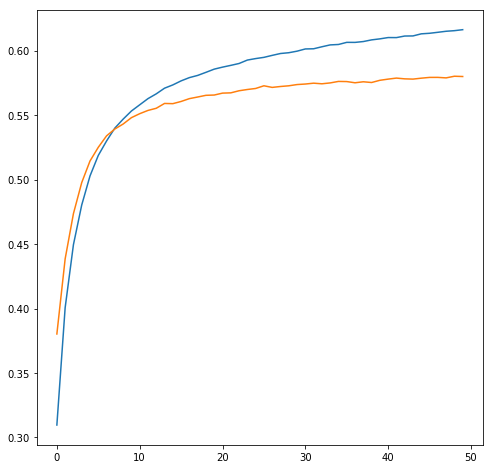

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [9]:
from keras.models import save_model

save_model(model, path + 'models/text_generation_model1024.h5')


## Evaluate model

In [10]:
from keras.models import load_model

model1 = load_model(path + 'models/text_generation_model1024.h5')


In [11]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [12]:
sentence = 'mire vuestra merced '
generate_text(sentence, 0.5, model)

/home/jorge/anaconda3/envs/keras2_py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.5
mire vuestra merced se ha de ser el voluntad, como tengo dicho, que ya soy tan industria que todas las manos, que el carro de la mancha, y que no la estaba hecho, y de despecho della, porque si no ha de dejar de contar los antiguos habían de ser fuerza y tuviera mala señora dulcinea, no hay poder dejar de ser los moros, y que no se ha de ser su escudero.

-yo no pudo saber que no la hallaba con un capitán de su amo, 


In [ ]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'mi señora dulcinea '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'el caballero andant'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


/home/jorge/anaconda3/envs/keras2_py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.2
mire vuestra merced que se le ofreció a su casa, y a las más de la caballería, y que es tan buena gala de la mancha, y que el cura y el barbero se le ofreció a la mesa, y que el caballero andante caballero andante caballero andante, que no la hallaba en la cabeza, y que se llamaba el de la caballería andante caballero andante.

-eso no es que es menester ser en el mundo, y que el caballero de la mancha, con la cual l

DIVERSITY:  0.5
mire vuestra merced que fue mejor de la salud de la ingeniosa de la infanta, como se
entretenía en el suelo, porque le falta a la del agravio que de su caballo andante caballero andante, y que no puede ver la cabeza, y todo el tiempo que no era posible que se le puso a la luna y estas y todas las cosas de la estada de las armas, y el caballero de la caballería, y ellos como el mesmo desdichado que el cura y la histor

DIVERSITY:  1
mire vuestra merced pude, preguntó
lo que oyer todas las costumbres lo sin padecer, y así se muestra tal del 